In [1]:
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.io import fits
from astropy.time import Time
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import (
    DataStore,
    FixedPointingInfo,
    Observation,
    observatory_locations,
)
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling.models import (
    ExpDecayTemporalModel,
    FoVBackgroundModel,
    Models,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    ConstantTemporalModel,
    EBLAbsorptionNormSpectralModel
)
from gammapy.catalog import CATALOG_REGISTRY

In [2]:
# Source
target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")

# Getting data from Fermi catalogs
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
source_4fgl = catalog_4fgl["4FGL J0242.6-0000"]          # NGC 1068
fermi_model = source_4fgl.sky_model()

# Specify the redshift of the source
redshift = 0.00379

# Load the EBL model. Here we use the model from Dominguez, 2011
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

# The Fermi model is multiplied by the EBL to get the final model
spectral_model = fermi_model.spectral_model * ebl 
spatial_model = PointSpatialModel.from_position(target_position)
temporal_model = ConstantTemporalModel(const=1)

sky_model = SkyModel(
                    spectral_model=spectral_model,
                    spatial_model=spatial_model,
                    temporal_model=temporal_model,
                    name="test_source",
                    )

bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

In [3]:
# Define the full model
models = Models([sky_model, bkg_model])

dataset_original = models.copy() 
print(models)

Models

Component 0: SkyModel

  Name                      : test_source
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : ConstantTemporalModel
  Parameters:
    index                         :      2.350   +/-    0.05             
    amplitude                     :   6.49e-13   +/- 4.3e-14 1 / (MeV s cm2)
    reference             (frozen):   1048.521       MeV         
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.004                   
    lon_0                         :     40.669   +/-    0.00 deg         
    lat_0                         :     -0.013   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :

In [4]:
irf_filename = "/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"  
IRF = load_irf_dict_from_file(irf_filename)

# this is a dictionary with the IRF extensions:
IRF

{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D at 0x1657d2450>,
 'psf': <gammapy.irf.psf.parametric.EnergyDependentMultiGaussPSF at 0x16636a3d0>,
 'edisp': <gammapy.irf.edisp.core.EnergyDispersion2D at 0x166374a50>,
 'bkg': <gammapy.irf.background.Background3D at 0x16571a0d0>}

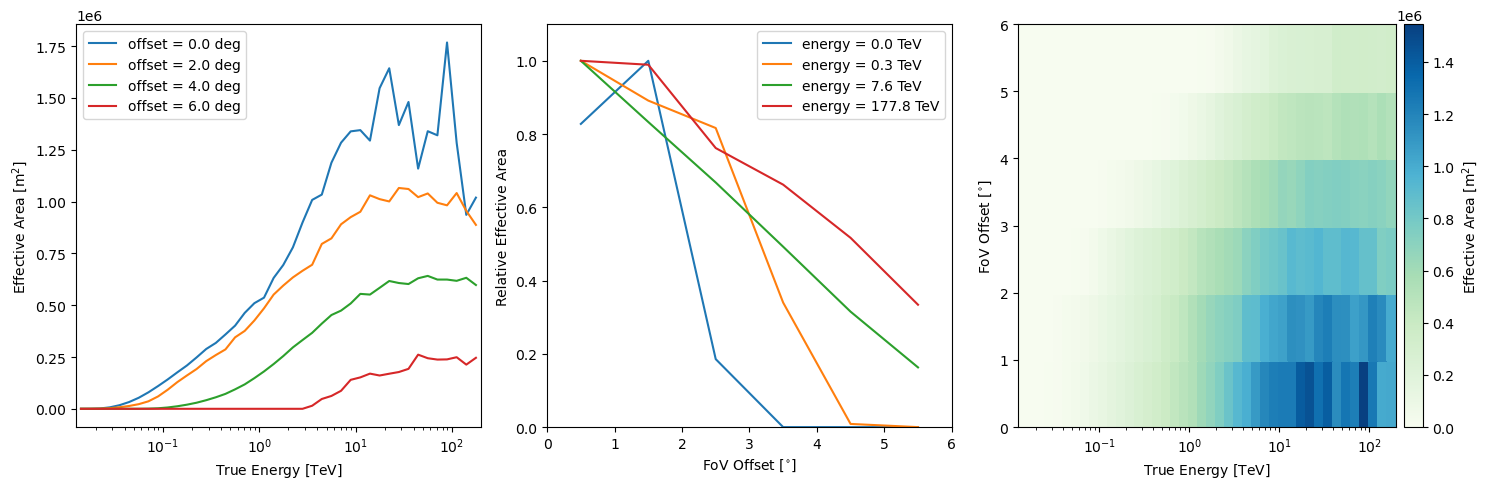

In [5]:
IRF["aeff"].peek()

In [6]:
livetime = 3 * u.hr              #observation time with units
obs_id = "0001"                   # obs_id could be everything

pointing = FixedPointingInfo(
    fixed_icrs=SkyCoord(40.169 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg"),
)

location = observatory_locations["cta_north"]

reference_time = Time("2026-05-28T00:00:00", format="isot", scale="utc")
observation = Observation.create(
                        obs_id=obs_id, 
                        pointing=pointing, 
                        livetime=livetime, 
                        irfs=IRF,
                        location=location,
                        reference_time = reference_time, 
                        tstart = 30 * u.min
              )                                   
print(observation)

Observation

	obs id            : 0001 
 	tstart            : 61188.02
	tstop             : 61188.15
	duration          : 10800.00 s
	pointing (icrs)   : 40.2 deg, -0.0 deg

	deadtime fraction : 0.0%



In [7]:
#Ereco ed Etrue must to be different: Etrue must have a larger range in order to reconstruct in the correct way (knowledge of
#the whole photon energy extension)

energy_axis = MapAxis.from_energy_bounds(
    "0.1 TeV", "100 TeV", nbin=10, per_decade=True
    )

# for the Edisp
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "200 TeV", nbin=20, per_decade=True, name="energy_true"
    )

migra_axis = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra" #If node_type = ‘edge’ then bounds correspond to the lower
                                                      #  and upper bound of the first and last bin.
    )    

In [8]:
# let's define the geometry of the simulation:
geom = WcsGeom.create(
    skydir=pointing.fixed_icrs,           
    width=(4, 4),         # gammapy uses a square not a circle 
    binsz=0.02,           # pixel size
    frame="icrs",
    axes=[energy_axis],    #in reco energy
)
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (np.int64(200), np.int64(200), 30)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 40.2 deg, -0.0 deg
	width      : 4.0 deg x 4.0 deg
	wcs ref    : 40.2 deg, -0.0 deg



In [9]:
#### MapDataset object with zer0-filled map
empty = MapDataset.create(
        geom,                               
        energy_axis_true=energy_axis_true,       #for the IRF maps
        migra_axis=migra_axis,                   #for the Edisp map
        name="my-dataset",                       #the name that will read the FoVBKG
            )

### Make maps for a single observation
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"]) #which maps to make (by default all)
dataset = maker.run(empty, observation)    #object

In [10]:
dataset.models = models

print(dataset)

MapDataset
----------

  Name                            : my-dataset 

  Total counts                    : 0 
  Total background counts         : 148686.32
  Total excess counts             : -148686.32

  Predicted counts                : 148712.91
  Predicted background counts     : 148686.32
  Predicted excess counts         : 26.59

  Exposure min                    : 9.44e+04 m2 s
  Exposure max                    : 1.81e+10 m2 s

  Number of total bins            : 1200000 
  Number of fit bins              : 1200000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 297425.83

  Number of models                : 2 
  Number of parameters            : 10
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : test_source
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : ConstantTemporalMod

In [11]:
#define the seed of random number generator 
seed=0

#simulate
sampler = MapDatasetEventSampler(random_state=seed)
events = sampler.run(dataset, observation)

The meta information will be empty here.


In [12]:
events.table

TIME,ENERGY_TRUE,RA_TRUE,DEC_TRUE,ENERGY,RA,DEC,MC_ID,EVENT_ID,DETX,DETY
s,TeV,deg,deg,TeV,deg,deg,,,deg,deg
float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64
1799.9999999999984,0.10126566026426181,38.6473298774841,-0.2582663330027162,0.10126566026426181,38.6473298774841,-0.2582663330027162,0,130120,-1.5216686055642654,-0.24527091740958992
1799.9999999999984,0.16251540629281616,40.47778759966195,-0.08940359980508857,0.16251540629281616,40.47778759966195,-0.08940359980508857,0,66422,0.3087874982871686,-0.07640378859839711
1799.9999999999984,0.11035767983537158,39.27692355638446,1.7728426909987165,0.11035767983537158,39.27692355638446,1.7728426909987165,0,96252,-0.8920827311908288,1.785841115324173
1799.9999999999984,0.12293600582603997,41.6574160715076,1.3469674168644172,0.12293600582603997,41.6574160715076,1.3469674168644172,0,71133,1.4884240496659016,1.3599630306011605
1800.0881494735702,0.2356901710104443,39.27412715709937,1.8187720733693702,0.2356901710104443,39.27412715709937,1.8187720733693702,0,30075,-0.8948793131005968,1.8317704878006966
1800.1727227340689,0.11634753677833443,40.73884629136166,0.9035648553441975,0.11634753677833443,40.73884629136166,0.9035648553441975,0,20023,0.569848345161675,0.9165642123877944
1800.2592797853843,0.1776258910638898,38.86719031173404,-1.9999148087083118,0.1776258910638898,38.86719031173404,-1.9999148087083118,0,98975,-1.301799408580298,-1.9869181640826141
1800.3792932831655,0.1524979192834605,38.90178898766936,-0.6716670812845387,0.1524979192834605,38.90178898766936,-0.6716670812845387,0,93597,-1.2672076745149858,-0.6586702606987969


In [13]:
print(f"Source events: {(events.table['MC_ID'] == 1).sum()}")
print(f"Background events: {(events.table['MC_ID'] == 0).sum()}")

Source events: 25
Background events: 148676


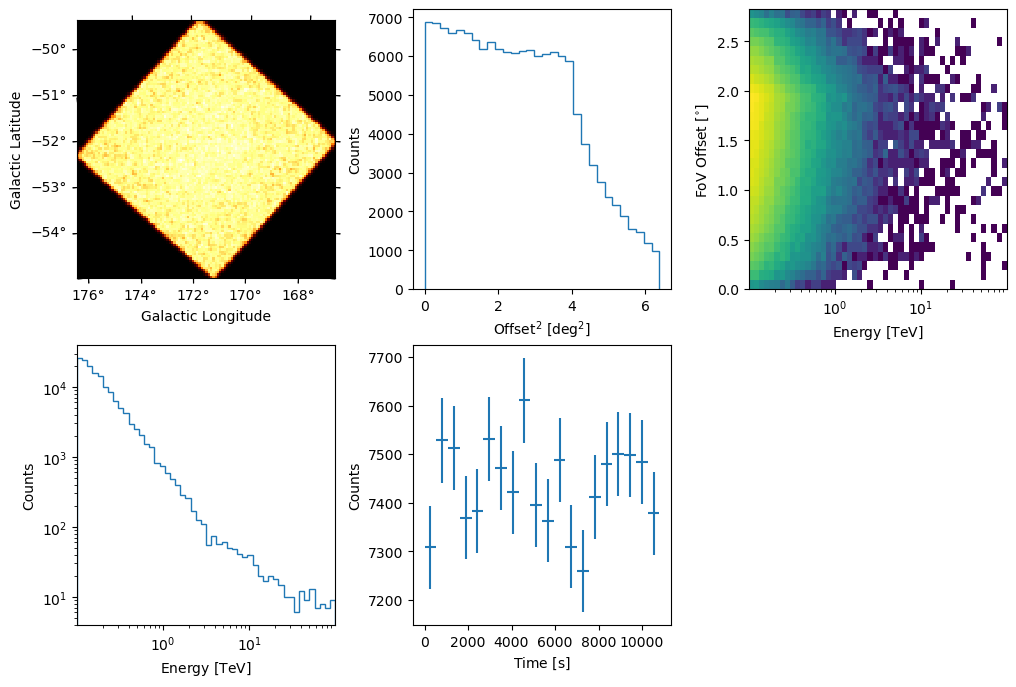

In [14]:
# let's have a look at the events
events.peek()
#counts map

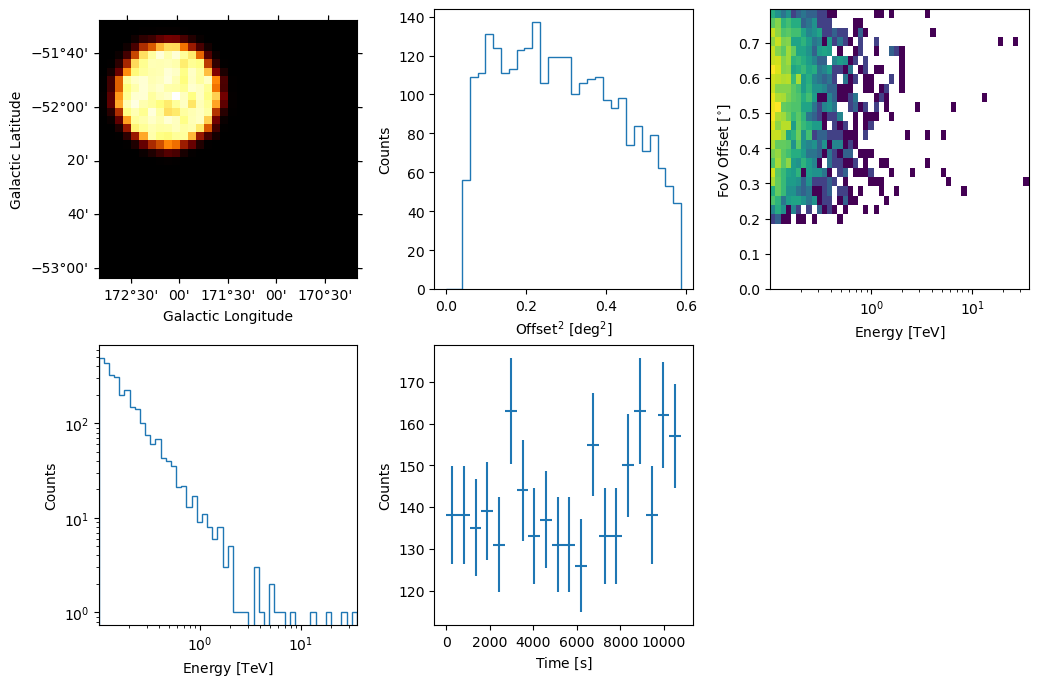

In [15]:
#We are focusing on our source
src_pos = SkyCoord(ra="40.669 deg", dec="-0.013 deg", 
                   frame="icrs")

region_sky = CircleSkyRegion(center=src_pos, radius=0.3 * u.deg)
evt = events.select_region(region_sky)
evt.peek()

In [16]:
# save the data into a fits file 
observation.events = events
observation.write("source_evt.fits", include_irfs=False, overwrite=True)

In [17]:
# tstart_obs = [0.083, 3, 10, 20, 25, 40, 80, 100, 200, 250, 300, 325, 350, 400] * u.d # Important so not all observations start at the same time (simultanous observations)
# livetime_obs = [2 , 2.5, 1.8, 2, 1.5, 1, 2.1, 2.3, 3, 3, 2, 2.5, 1.8, 1] * u.hr # 30 mins observations (gives an estimate of how many runs)
# angle_wobble = [0, 90, 180, 270, 0, 90, 180, 270, 0, 90, 180, 270, 0, 90] * u.deg # wobble angle of the observations. Creates that circular shape
# amplitude_obs = [2.5e-13, 4e-13, 7e-13, 12e-13, 20e-13, 50e-13, 35e-13, 25e-13, 5e-13, 2e-13] * u.cm**-2 * u.s**-1 * u.TeV**-1

In [18]:
# Parameters
total_hours = 28
obs_duration = 0.5  # 30 minutes in hours
n_obs = int(total_hours / obs_duration)

# Generate tstart_obs with increasing values (non-simultaneous), spread out in time
# We use an arbitrary starting point and step to ensure separation
tstart_obs = np.linspace(0.083, 5, n_obs) * u.d

# All observations are 30 minutes
livetime_obs = np.full(n_obs, obs_duration) * u.hr

# Generate angle_wobble cycling through [0, 90, 180, 270]
base_angles = [0, 90, 180, 270]
angle_wobble = [base_angles[i % 4] for i in range(n_obs)] * u.deg

In [19]:
bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

In [20]:
spatial_model = PointSpatialModel.from_position(target_position)
temporal_model = ConstantTemporalModel(const=1)

for i, (tobs, liveobs, wobobs) in enumerate(zip(tstart_obs, livetime_obs, angle_wobble)):
    # Getting data from Fermi catalogs
    catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
    source_4fgl = catalog_4fgl["4FGL J0242.6-0000"]          # NGC 1068
    fermi_model = source_4fgl.sky_model()

    # Specify the redshift of the source
    redshift = 0.00379

    # Load the EBL model. Here we use the model from Dominguez, 2011
    ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

    # The Fermi model is multiplied by the EBL to get the final model
    spectral_model = fermi_model.spectral_model * ebl 

    sky_model = SkyModel(
                        spectral_model=spectral_model,
                        spatial_model=spatial_model,
                        temporal_model=temporal_model,
                        name="test_source",
                        )
    model_obs = Models([sky_model, bkg_model])

    pointing_obs = target_position.directional_offset_by(wobobs, 0.5*u.deg)
    obs = Observation.create(
                            obs_id=i, 
                            pointing=pointing_obs, 
                            livetime=liveobs, 
                            irfs=IRF,
                            location=location,
                            reference_time = reference_time, 
                            tstart = tobs
                  )    

    dataset = maker.run(empty, obs) 
    dataset.models = model_obs

    sampler = MapDatasetEventSampler(random_state=0)
    events = sampler.run(dataset, obs)

    obs.events = events
    obs.write(f"./sims/events_obs{i}.fits", include_irfs=False, overwrite=True)

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/data/observations.py:294: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
The meta information will be empty here.
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/data/observations.py:294: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
The meta information will be empty here.
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/data/observations.py:294: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
The meta information will be empty here.
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/data/observations.py:294: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
The meta information 

In [1]:
import matplotlib.pyplot as plt

import glob, os, itertools
from pathlib import Path

from regions import PointSkyRegion, CircleSkyRegion

import numpy as np

import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.time import Time
from astropy.table import Table

from gammapy.data import DataStore, Observation, observatory_locations, EventList
from gammapy.datasets import (
    MapDataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import ASmoothMapEstimator, TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators.utils import resample_energy_edges, find_peaks, find_peaks_in_flux_map
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import (
    MapDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, RegionGeom, RegionNDMap, WcsGeom, Map, TimeMapAxis
from gammapy.modeling.models import (
    PowerLawNormSpectralModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel
)

import warnings

In [2]:
input_filenames = []
input_filenames.append(glob.glob(os.path.join("./sims/", '*.fits')))
input_filenames = tuple(itertools.chain.from_iterable(input_filenames))

datastore = DataStore.from_events_files(np.sort(input_filenames), 
                                        irfs_paths="/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits")
datastore.hdu_table.write("hdu-index.fits.gz", overwrite=True)
datastore.obs_table.write("obs-index.fits.gz", overwrite=True)

In [3]:
datastore.obs_table

OBS_ID,TSTART,TSTOP,ONTIME,LIVETIME,DEADC,TELESCOP,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,EVENTS_FILENAME,EVENT_COUNT,CALDB,IRF,IRF_FILENAME,MJDREFI,MJDREFF,TIMEUNIT,TIMESYS,TIMEREF
,s,s,s,s,,,deg,deg,deg,deg,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,str13,str13,str13,str13,str1,str8,str24,int64,str13,str13,str189,int64,float64,str1,str2,str5
0,7171.200000000006,8971.2,1799.9999999999936,1799.9999999999936,1.0,CTA,40.669,0.4869999999999999,171.56100364863156,-51.56311119787755,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,NGC_1068,sims/events_obs0.fits,24188,NOT AVAILABLE,NOT AVAILABLE,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits,61188,0.000800740737759042,s,tt,LOCAL
1,14895.36,16695.360000000004,1800.0000000000032,1800.0000000000032,1.0,CTA,41.16900001286943,-0.0129995049998257,172.69766568256216,-51.595774065143495,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,NGC_1068,sims/events_obs1.fits,23365,NOT AVAILABLE,NOT AVAILABLE,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits,61188,0.000800740737759042,s,tt,LOCAL
10,84412.8,86212.79999999999,1800.0000000000032,1800.0000000000032,1.0,CTA,40.669,-0.513,172.65327684026465,-52.30234689412969,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,NGC_1068,sims/events_obs10.fits,24188,NOT AVAILABLE,NOT AVAILABLE,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits,61188,0.000800740737759042,s,tt,LOCAL
11,92136.96000000002,93936.95999999999,1799.9999999999936,1799.9999999999936,1.0,CTA,40.16899998713056,-0.01299950499982582,171.49862014667832,-52.26916581926981,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,NGC_1068,sims/events_obs11.fits,24728,NOT AVAILABLE,NOT AVAILABLE,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits,61188,0.000800740737759042,s,tt,LOCAL
12,99861.12000000001,101661.11999999997,1799.9999999999936,1799.9999999999936,1.0,CTA,40.669,0.4869999999999999,171.56100364863156,-51.56311119787755,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,NGC_1068,sims/events_obs12.fits,24188,NOT AVAILABLE,NOT AVAILABLE,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits,61188,0.000800740737759042,s,tt,LOCAL
13,119880.88163265307,123480.88163265304,3600.0000000000064,3600.0000000000064,1.0,CTA,41.16900001286943,-0.0129995049998257,172.69766568256216,-51.595774065143495,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,NGC_1068,sims/events_obs13 2.fits,46515,NOT AVAILABLE,NOT AVAILABLE,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits,61188,0.000800740737759042,s,tt,LOCAL
13,107585.28000000001,109385.27999999998,1799.9999999999936,1799.9999999999936,1.0,CTA,41.16900001286943,-0.0129995049998257,172.69766568256216,-51.595774065143495,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,NGC_1068,sims/events_obs13.fits,23365,NOT AVAILABLE,NOT AVAILABLE,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits,61188,0.000800740737759042,s,tt,LOCAL
14,115309.44,117109.43999999997,1799.999

In [4]:
datastore.hdu_table

HDU_TYPE,HDU_CLASS,HDU_NAME,OBS_ID,FILE_DIR,FILE_NAME
str6,str10,str21,int64,str131,str57
events,events,EVENTS,0,sims,events_obs0.fits
gti,gti,GTI,0,sims,events_obs0.fits
aeff,aeff_2d,EFFECTIVE AREA,0,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS,Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits
edisp,edisp_2d,ENERGY DISPERSION,0,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS,Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits
psf,psf_3gauss,POINT SPREAD FUNCTION,0,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS,Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits
bkg,bkg_3d,BACKGROUND,0,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS,Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits
events,events,EVENTS,1,sims,events_obs1.fits
gti,gti,GTI,1,sims,events_obs1.fits
aeff,aeff_2d,EFFECTIVE AREA,1,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS,Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits


In [5]:
print(f"The mean exposure of the runs is {np.mean(datastore.obs_table['LIVETIME']) * u.s}\n")
print(f"The total exposure time is {(np.sum(datastore.obs_table['LIVETIME']) * u.s).to('hr')}\n")
print(f"These are the selected runs: \n {datastore.obs_table['OBS_ID']}")

The mean exposure of the runs is 1831.5789473684194 s

The total exposure time is 28.999999999999975 h

These are the selected runs: 
 OBS_ID
------
     0
     1
    10
    11
    12
    13
    13
    14
    15
    16
   ...
    50
    51
    52
    53
    54
    55
     6
     7
     8
     9
Length = 57 rows


In [6]:
observations = datastore.get_observations(obs_id=list(datastore.obs_table['OBS_ID']))

Found multiple HDU matching: OBS_ID = 13, HDU_TYPE = events, HDU_CLASS = {hdu_class}. Returning the first entry, which has HDU_TYPE = events and HDU_CLASS = events
Found multiple HDU matching: OBS_ID = 13, HDU_TYPE = gti, HDU_CLASS = {hdu_class}. Returning the first entry, which has HDU_TYPE = gti and HDU_CLASS = gti
Found multiple HDU matching: OBS_ID = 13, HDU_TYPE = aeff, HDU_CLASS = {hdu_class}. Returning the first entry, which has HDU_TYPE = aeff and HDU_CLASS = aeff_2d
Found multiple HDU matching: OBS_ID = 13, HDU_TYPE = edisp, HDU_CLASS = {hdu_class}. Returning the first entry, which has HDU_TYPE = edisp and HDU_CLASS = edisp_2d
Found multiple HDU matching: OBS_ID = 13, HDU_TYPE = psf, HDU_CLASS = {hdu_class}. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss
Found multiple HDU matching: OBS_ID = 13, HDU_TYPE = bkg, HDU_CLASS = {hdu_class}. Returning the first entry, which has HDU_TYPE = bkg and HDU_CLASS = bkg_3d
Found multiple HDU matching: OBS_ID 

In [7]:
# let's find the highest quality run:
longest_obs = np.zeros((len(observations)), float)
for i,obs in enumerate(observations):
    longest_obs[i] = len(obs.events.table)
print(f"The run with the highest counting statistics is observation #{int(np.argmax(longest_obs))}," + 
      f"i.e. ObsID {observations[int(np.argmax(longest_obs))].obs_id}")

The run with the highest counting statistics is observation #5,i.e. ObsID 13


In [8]:
# let's inspect this observation
observations[int(np.argmax(longest_obs))].events

In [9]:
# let's inspect the GTI
observations[int(np.argmax(longest_obs))].gti

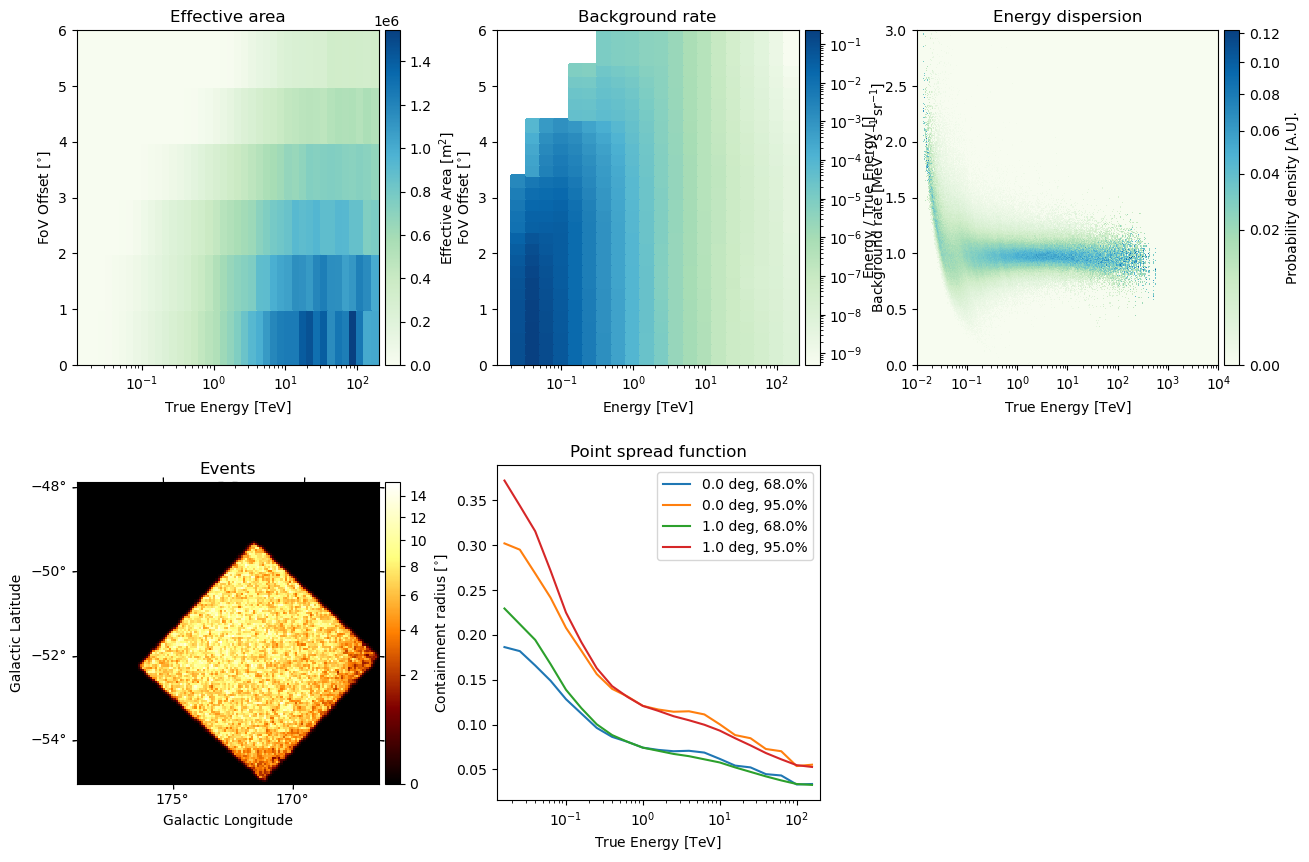

In [10]:
# let's have a quick look of the IRF/Events
observations[int(np.argmax(longest_obs))].peek()

In [11]:
bkg = "FoV"

In [12]:
# we consider a square map of size 2.0 deg, spatially binned with bins of 0.02 deg:
# we define the ON region, assuming a circle of 0.3 deg of radius, for the source:
width = 2    #deg
binsz = 0.02 #deg 
radius= 0.2  #deg

target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")
on_region_radius = Angle(radius * u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

npix = int(width/binsz)

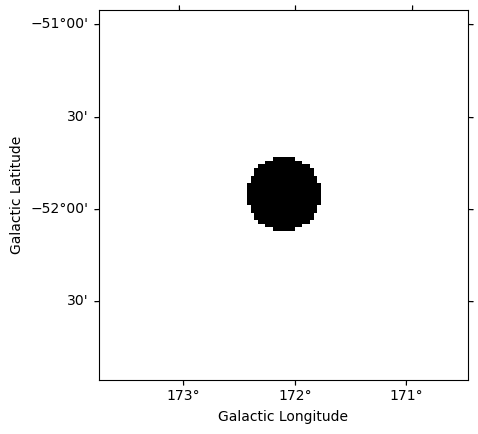

In [13]:
# let's define an exclusion region, in order to better estimate the bkg:
exclusion_region = CircleSkyRegion(
    center=target_position,
    radius=radius * u.deg,
)

geom_excl = WcsGeom.create(
    npix=(npix, npix), binsz=binsz, skydir=target_position.galactic, proj="TAN", frame="galactic"
    #npix=(npix, npix), binsz=binsz, skydir=w1.galactic, proj="TAN", frame="galactic"
)

exclusion_mask = ~geom_excl.region_mask([exclusion_region])
exclusion_mask.plot()
plt.show()

In [14]:
# Create the reconstruced energy range:
e_min, e_max = 0.1 * u.TeV, 100 * u.TeV
energy_axis = MapAxis.from_energy_bounds(
    e_min, e_max, nbin=10, per_decade=True, unit="TeV", name="energy"
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.01, 300, nbin=10, per_decade=True, unit="TeV", name="energy_true"
)

In [15]:
if bkg == "FoV":
    geom = WcsGeom.create(
        skydir=(target_position.galactic.l.deg , target_position.galactic.b.deg),
        binsz=binsz,
        width=(width, width),
        frame="galactic",
        proj="CAR",
        axes=[energy_axis],
    )

    stacked = MapDataset.create(
        geom=geom, energy_axis_true=energy_axis_true, name="my-dataset"
    )

    dataset_maker = MapDatasetMaker()
    
    maker_fov = FoVBackgroundMaker(method="scale", 
                                   exclusion_mask=exclusion_mask,
                                   )

In [16]:
# let's impone a safe range for the analysis: we consider only events at a distance from the pointing direction < 3 deg.
offset_max = 3 * u.deg
safe_mask_masker = SafeMaskMaker(
    methods=["offset-max", "aeff-default"], offset_max=offset_max
    #methods=["offset-max", "aeff-max"], offset_max=offset_max, aeff_percent=10
)

In [17]:
# let's create the dataset for each observation and stack them all:
for i, observation in enumerate(observations):
    if bkg == "FoV":
        dataset = dataset_maker.run(stacked.copy(name=str(observation.obs_id)), observation)
        
        # A MapDataset is filled in this cutout geometry
        dataset = safe_mask_masker.run(dataset, observation)
        dataset = maker_fov.run(dataset)
        
        # The data quality cut is applied
        stacked.stack(dataset)
        
        print(f"{i+1} of {len(observations)}, Background norm obs {observation.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}")

No default upper safe energy threshold defined for obs 0
No default lower safe energy threshold defined for obs 0


1 of 57, Background norm obs 0: 1.00


No default upper safe energy threshold defined for obs 1
No default lower safe energy threshold defined for obs 1


2 of 57, Background norm obs 1: 0.99


No default upper safe energy threshold defined for obs 10
No default lower safe energy threshold defined for obs 10


3 of 57, Background norm obs 10: 0.99


No default upper safe energy threshold defined for obs 11
No default lower safe energy threshold defined for obs 11


4 of 57, Background norm obs 11: 0.98


No default upper safe energy threshold defined for obs 12
No default lower safe energy threshold defined for obs 12


5 of 57, Background norm obs 12: 1.00


No default upper safe energy threshold defined for obs 13
No default lower safe energy threshold defined for obs 13


6 of 57, Background norm obs 13: 0.99


No default upper safe energy threshold defined for obs 13
No default lower safe energy threshold defined for obs 13


7 of 57, Background norm obs 13: 0.99


No default upper safe energy threshold defined for obs 14
No default lower safe energy threshold defined for obs 14


8 of 57, Background norm obs 14: 0.99


No default upper safe energy threshold defined for obs 15
No default lower safe energy threshold defined for obs 15


9 of 57, Background norm obs 15: 0.98


No default upper safe energy threshold defined for obs 16
No default lower safe energy threshold defined for obs 16


10 of 57, Background norm obs 16: 1.00


No default upper safe energy threshold defined for obs 17
No default lower safe energy threshold defined for obs 17


11 of 57, Background norm obs 17: 0.99


No default upper safe energy threshold defined for obs 18
No default lower safe energy threshold defined for obs 18


12 of 57, Background norm obs 18: 0.99


No default upper safe energy threshold defined for obs 19
No default lower safe energy threshold defined for obs 19


13 of 57, Background norm obs 19: 0.98


No default upper safe energy threshold defined for obs 2
No default lower safe energy threshold defined for obs 2


14 of 57, Background norm obs 2: 0.99


No default upper safe energy threshold defined for obs 20
No default lower safe energy threshold defined for obs 20


15 of 57, Background norm obs 20: 1.00


No default upper safe energy threshold defined for obs 21
No default lower safe energy threshold defined for obs 21


16 of 57, Background norm obs 21: 0.99


No default upper safe energy threshold defined for obs 22
No default lower safe energy threshold defined for obs 22


17 of 57, Background norm obs 22: 0.99


No default upper safe energy threshold defined for obs 23
No default lower safe energy threshold defined for obs 23


18 of 57, Background norm obs 23: 0.98


No default upper safe energy threshold defined for obs 24
No default lower safe energy threshold defined for obs 24


19 of 57, Background norm obs 24: 1.00


No default upper safe energy threshold defined for obs 25
No default lower safe energy threshold defined for obs 25


20 of 57, Background norm obs 25: 0.99


No default upper safe energy threshold defined for obs 26
No default lower safe energy threshold defined for obs 26


21 of 57, Background norm obs 26: 0.99


No default upper safe energy threshold defined for obs 27
No default lower safe energy threshold defined for obs 27


22 of 57, Background norm obs 27: 0.98


No default upper safe energy threshold defined for obs 28
No default lower safe energy threshold defined for obs 28


23 of 57, Background norm obs 28: 1.00


No default upper safe energy threshold defined for obs 29
No default lower safe energy threshold defined for obs 29


24 of 57, Background norm obs 29: 0.99


No default upper safe energy threshold defined for obs 3
No default lower safe energy threshold defined for obs 3


25 of 57, Background norm obs 3: 0.98


No default upper safe energy threshold defined for obs 30
No default lower safe energy threshold defined for obs 30


26 of 57, Background norm obs 30: 0.99


No default upper safe energy threshold defined for obs 31
No default lower safe energy threshold defined for obs 31


27 of 57, Background norm obs 31: 0.98


No default upper safe energy threshold defined for obs 32
No default lower safe energy threshold defined for obs 32


28 of 57, Background norm obs 32: 1.00


No default upper safe energy threshold defined for obs 33
No default lower safe energy threshold defined for obs 33


29 of 57, Background norm obs 33: 0.99


No default upper safe energy threshold defined for obs 34
No default lower safe energy threshold defined for obs 34


30 of 57, Background norm obs 34: 0.99


No default upper safe energy threshold defined for obs 35
No default lower safe energy threshold defined for obs 35


31 of 57, Background norm obs 35: 0.98


No default upper safe energy threshold defined for obs 36
No default lower safe energy threshold defined for obs 36


32 of 57, Background norm obs 36: 1.00


No default upper safe energy threshold defined for obs 37
No default lower safe energy threshold defined for obs 37


33 of 57, Background norm obs 37: 0.99


No default upper safe energy threshold defined for obs 38
No default lower safe energy threshold defined for obs 38


34 of 57, Background norm obs 38: 0.99


No default upper safe energy threshold defined for obs 39
No default lower safe energy threshold defined for obs 39


35 of 57, Background norm obs 39: 0.98


No default upper safe energy threshold defined for obs 4
No default lower safe energy threshold defined for obs 4


36 of 57, Background norm obs 4: 1.00


No default upper safe energy threshold defined for obs 40
No default lower safe energy threshold defined for obs 40


37 of 57, Background norm obs 40: 1.00


No default upper safe energy threshold defined for obs 41
No default lower safe energy threshold defined for obs 41


38 of 57, Background norm obs 41: 0.99


No default upper safe energy threshold defined for obs 42
No default lower safe energy threshold defined for obs 42


39 of 57, Background norm obs 42: 0.99


No default upper safe energy threshold defined for obs 43
No default lower safe energy threshold defined for obs 43


40 of 57, Background norm obs 43: 0.98


No default upper safe energy threshold defined for obs 44
No default lower safe energy threshold defined for obs 44


41 of 57, Background norm obs 44: 1.00


No default upper safe energy threshold defined for obs 45
No default lower safe energy threshold defined for obs 45


42 of 57, Background norm obs 45: 0.99


No default upper safe energy threshold defined for obs 46
No default lower safe energy threshold defined for obs 46


43 of 57, Background norm obs 46: 0.99


No default upper safe energy threshold defined for obs 47
No default lower safe energy threshold defined for obs 47


44 of 57, Background norm obs 47: 0.98


No default upper safe energy threshold defined for obs 48
No default lower safe energy threshold defined for obs 48


45 of 57, Background norm obs 48: 1.00


No default upper safe energy threshold defined for obs 49
No default lower safe energy threshold defined for obs 49


46 of 57, Background norm obs 49: 0.99


No default upper safe energy threshold defined for obs 5
No default lower safe energy threshold defined for obs 5


47 of 57, Background norm obs 5: 0.99


No default upper safe energy threshold defined for obs 50
No default lower safe energy threshold defined for obs 50


48 of 57, Background norm obs 50: 0.99


No default upper safe energy threshold defined for obs 51
No default lower safe energy threshold defined for obs 51


49 of 57, Background norm obs 51: 0.98


No default upper safe energy threshold defined for obs 52
No default lower safe energy threshold defined for obs 52


50 of 57, Background norm obs 52: 1.00


No default upper safe energy threshold defined for obs 53
No default lower safe energy threshold defined for obs 53


51 of 57, Background norm obs 53: 0.99


No default upper safe energy threshold defined for obs 54
No default lower safe energy threshold defined for obs 54


52 of 57, Background norm obs 54: 0.99


No default upper safe energy threshold defined for obs 55
No default lower safe energy threshold defined for obs 55


53 of 57, Background norm obs 55: 0.98


No default upper safe energy threshold defined for obs 6
No default lower safe energy threshold defined for obs 6


54 of 57, Background norm obs 6: 0.99


No default upper safe energy threshold defined for obs 7
No default lower safe energy threshold defined for obs 7


55 of 57, Background norm obs 7: 0.98


No default upper safe energy threshold defined for obs 8
No default lower safe energy threshold defined for obs 8


56 of 57, Background norm obs 8: 1.00


No default upper safe energy threshold defined for obs 9
No default lower safe energy threshold defined for obs 9


57 of 57, Background norm obs 9: 0.99


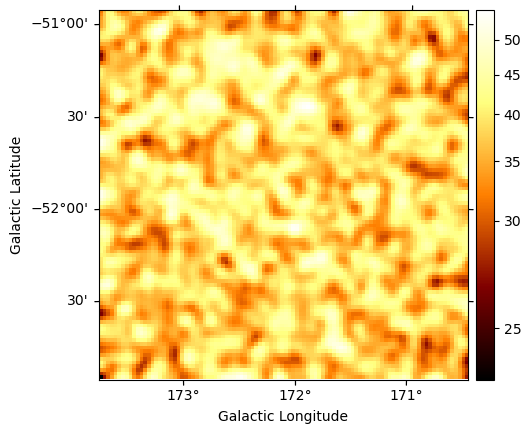

In [18]:
# plot the counts map
if bkg == "FoV":
    stacked.counts.sum_over_axes().smooth(0.03 * u.deg).plot(stretch="sqrt", add_cbar=True)
plt.show()

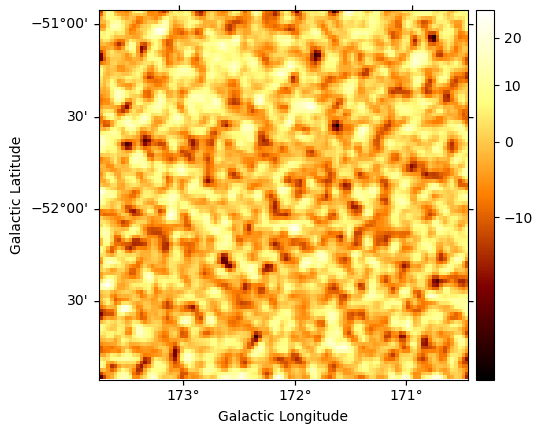

In [19]:
# plot the excess map
excess = stacked.excess.sum_over_axes()
excess.smooth("0.02 deg").plot(stretch="sqrt", add_cbar=True)
plt.show()

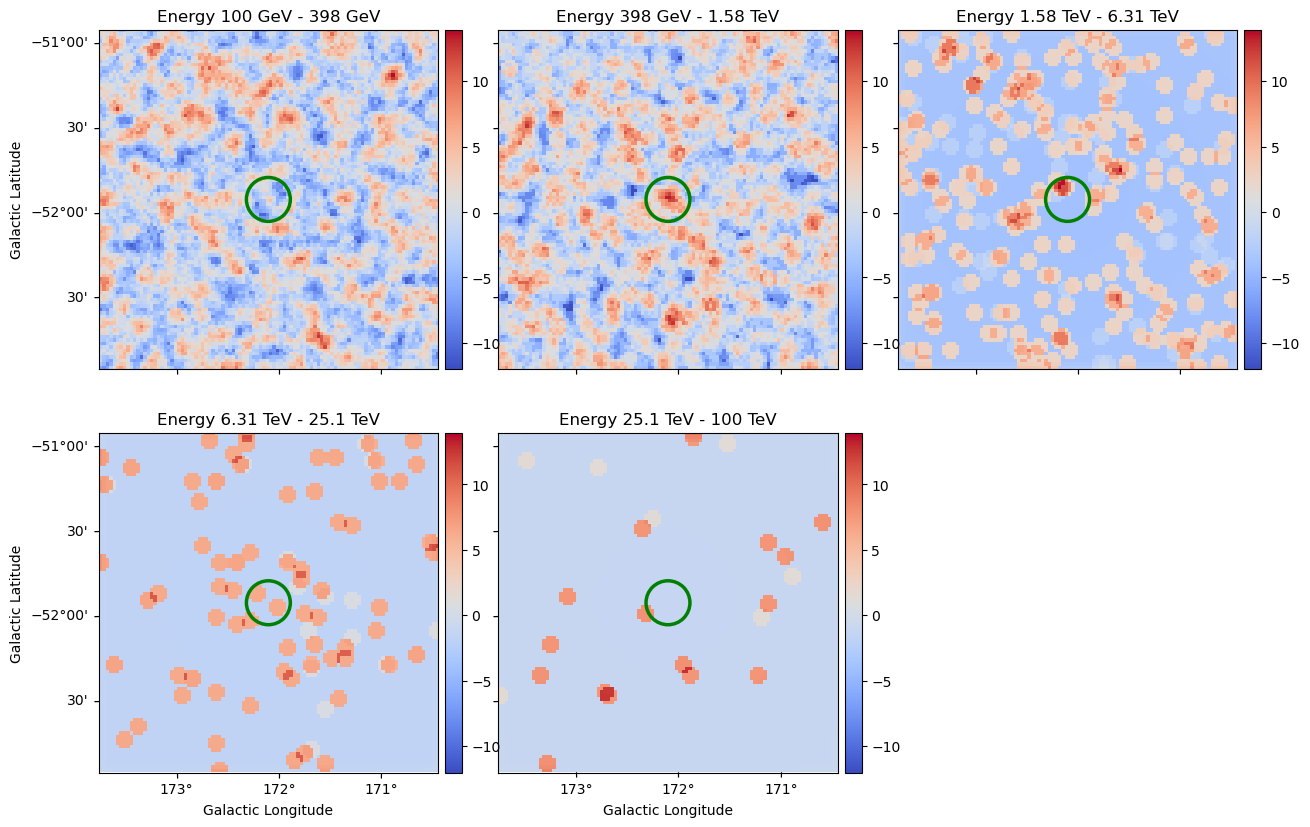

In [20]:
# let's consider more than one energy bin and a correlation radius of 0.1 deg
estimator = ExcessMapEstimator(
    correlation_radius="0.05 deg",
    selection_optional="all",
    #energy_edges=[0.5, 2, 5, 10, 30, 100] * u.TeV,
    energy_edges=energy_axis.downsample(6).edges,
)

result = estimator.run(stacked)
ax = result["sqrt_ts"].plot_grid(
    figsize=(15, 10), cmap="coolwarm", add_cbar=True, 
    vmin=np.min(result["sqrt_ts"].data[~np.isnan(result["sqrt_ts"].data)]), 
    vmax=np.max(result["sqrt_ts"].data[~np.isnan(result["sqrt_ts"].data)]), 
    ncols=3)

for p in ax.reshape(ax.size):
    p.scatter(
        target_position.galactic.l.deg, target_position.galactic.b.deg,
        transform=p.get_transform("galactic"),
        color="None", edgecolor="g", marker="o",
        s=1000, lw=2.5,
    )

plt.show()

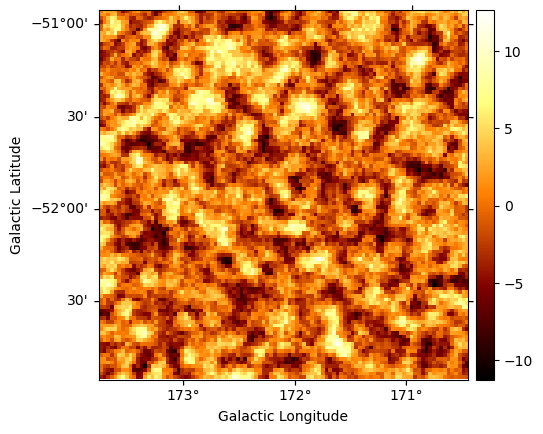

In [21]:
excess_estimator_integrated = ExcessMapEstimator(
    correlation_radius="0.05 deg", selection_optional="all", n_sigma=1,
    n_sigma_ul=5,
    energy_edges=[0.1, 100] * u.TeV,
    correlate_off=True
)
excess_integrated = excess_estimator_integrated.run(stacked)

excess_integrated["sqrt_ts"].plot(add_cbar=True)
plt.show()

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
12.662,64,9,39.90914,-0.41651
12.442,86,86,40.62097,1.01824
12.218,59,32,40.29284,-0.14379
11.935,56,73,40.88941,0.42199
11.524,40,66,41.03169,0.10301
11.258,16,94,41.76363,0.19379
11.061,25,74,41.36121,0.01927
11.049,5,76,41.68386,-0.22049


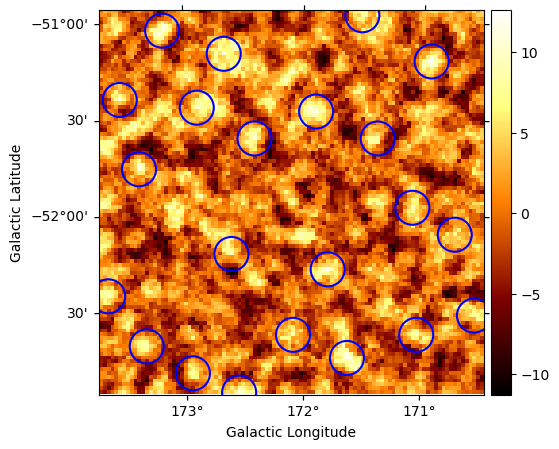

In [23]:
# set a threshold of detection at 4 sigma and a minimum distance amongst detected source of 0.2 deg:
sources = find_peaks(excess_integrated["sqrt_ts"], threshold=5, min_distance="0.2 deg")
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = excess_integrated["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"], sources["dec"],
    transform=ax.get_transform("icrs"),
    color="None", edgecolor="b", marker="o",
    s=600, lw=1.5,
)
plt.show()

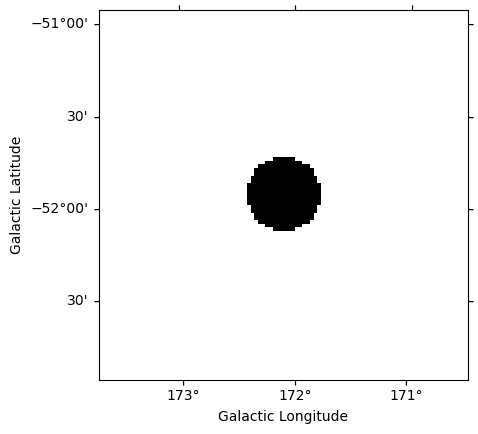

In [24]:
# get the geom that we use
geom = stacked.counts.geom
energy_axis = stacked.counts.geom.axes["energy"]
geom_image = geom.to_image().to_cube([energy_axis.squash()])

# Make the exclusion mask
regions = CircleSkyRegion(center=target_position, radius=0.2 * u.deg)
exclusion_mask = ~geom_image.region_mask([regions])
exclusion_mask.sum_over_axes().plot()
plt.show()

In [18]:
import matplotlib.pyplot as plt
import glob, os, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.time import Time
from astropy.table import Table
from gammapy.data import Observation, observatory_locations, EventList
from gammapy.datasets import MapDataset, MapDatasetEventSampler, FluxPointsDataset
from gammapy.estimators import ASmoothMapEstimator, TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators.utils import resample_energy_edges
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker, RingBackgroundMaker, SafeMaskMaker
from gammapy.datasets import MapDataset, MapDatasetOnOff
from gammapy.makers import MapDatasetMaker, WobbleRegionsFinder
from gammapy.maps import MapAxis, RegionNDMap, WcsGeom, Map, TimeMapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ConstantSpectralModel,
    FoVBackgroundModel,
    LightCurveTemplateTemporalModel,
    Models,
    PointSpatialModel,
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    SkyModel,
)
from regions import PointSkyRegion, CircleSkyRegion

from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    SkyModel,
    PiecewiseNormSpectralModel,
    PowerLawNormSpectralModel,
    LogParabolaSpectralModel,
)

import warnings
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [19]:
# let's load the previously created Observation index files:
datastore = DataStore.from_dir("./")

In [20]:
observations = datastore.get_observations(obs_id=list(datastore.obs_table['OBS_ID']))

Observations selected: 100 out of 100.


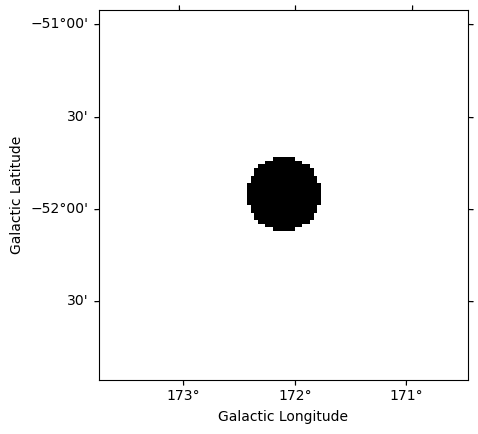

In [21]:
# we consider a square map of size 2.0 deg, spatially binned with bins of 0.02 deg;
# we define the ON region, assuming a circle of 0.2 deg of radius, for the source;
width = 2.0  #deg
binsz = 0.02 #deg
radius= 0.2  #deg

# let's define an exclusion region, in order to better estimate the bkg:
target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")
on_region_radius = Angle(radius * u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

npix = int(width/binsz)

exclusion_region = CircleSkyRegion(
    center=target_position,
    radius=radius * u.deg,
)

geom_excl = WcsGeom.create(
    npix=(npix, npix), binsz=binsz, skydir=target_position.galactic, proj="TAN", frame="galactic"
    #npix=(npix, npix), binsz=binsz, skydir=w1.galactic, proj="TAN", frame="galactic"
)

exclusion_mask = ~geom_excl.region_mask([exclusion_region])
exclusion_mask.plot()
plt.show()

In [22]:
# Create the reconstruced energy range:
e_min, e_max = 0.1 * u.TeV, 100 * u.TeV

energy_axis = MapAxis.from_energy_bounds(
    e_min, e_max, nbin=5, per_decade=True, unit="TeV", name="energy"
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.01, 300, nbin=10, per_decade=True, unit="TeV", name="energy_true"
)

# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)

# tell the background maker to determine the reflected regions, excluding the source region:
maker_fov = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

# let's impone a safe range for the analysis: we consider only events at a distance from the pointing direction < 1 deg.
offset_max = 2 * u.deg
safe_mask_masker = SafeMaskMaker(
    methods=["aeff-default","offset-max"], offset_max=offset_max
)

In [23]:
# create a counts map for visualisation later...
counts = Map.create(skydir=target_position, width=3)

# let's create the dataset for each observation and stack them all:
datasets = Datasets()

# let's loop over observations
for observation in observations:
    # generate a dataset object
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)), observation
    )
    # fill the dataset with the events of the observation
    counts.fill_events(observation.events)

    # calculate the bkg
    dataset_on_off = maker_fov.run(dataset, observation)
    # set a safe range for the analysis
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)

    datasets.append(dataset_on_off)

No default upper safe energy threshold defined for obs 0
No default lower safe energy threshold defined for obs 0
No default upper safe energy threshold defined for obs 1
No default lower safe energy threshold defined for obs 1
No default upper safe energy threshold defined for obs 10
No default lower safe energy threshold defined for obs 10
No default upper safe energy threshold defined for obs 11
No default lower safe energy threshold defined for obs 11
No default upper safe energy threshold defined for obs 12
No default lower safe energy threshold defined for obs 12
No default upper safe energy threshold defined for obs 13
No default lower safe energy threshold defined for obs 13
No default upper safe energy threshold defined for obs 14
No default lower safe energy threshold defined for obs 14
No default upper safe energy threshold defined for obs 15
No default lower safe energy threshold defined for obs 15
No default upper safe energy threshold defined for obs 16
No default lower s

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/regions/shapes/circle.py:160: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


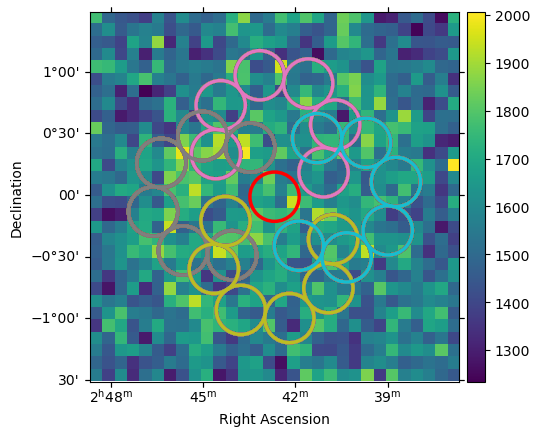

In [24]:
#plot the counts map overimposing the ON-OFF regions
ax = counts.smooth(0.05 * u.deg).plot(stretch="linear", cmap="viridis", add_cbar=True)
geom.plot_region(ax=ax, kwargs_point={"color": "k", "marker": "*"}, color="r", linewidth=2.5)
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets, linewidth=2.5)
plt.show()

In [25]:
# Individual
info_table=datasets.info_table()
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str2,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
0,226,17.33333333333337,1.0939189321868907,208.66666666666663,211.1428571428571,211.1428571428571,nan,28959.036692562575,2667793602.764939,1799.9999999999936,1799.9999999999936,0.125555555555556,0.11592592592592632,0.009629629629629684,15,15,wstat,9.152954075805518,1252,15.0,90.00000000000001,0.16666666666666663
1,208,-14.833333333333371,-0.9319716498044627,222.83333333333334,220.71428571428567,220.71428571428567,nan,28959.036692562586,2667793602.76494,1799.9999999999936,1799.9999999999936,0.11555555555555597,0.12379629629629674,-0.008240740740740791,15,15,wstat,12.99579955444706,1337,15.0,89.99999999999999,0.16666666666666669
10,227,20.0,1.2641933133003362,206.99999999999997,209.8571428571428,209.8571428571428,nan,28959.0366925629,2667793602.764974,1800.0000000000127,1800.0000000000127,0.12611111111111023,0.11499999999999917,0.011111111111111032,15,15,wstat,7.063041314799806,1242,15.0,90.0,0.16666666666666666
11,225,20.166666666666686,1.281030311817922,204.83333333333331,207.71428571428572,207.71428571428572,nan,28959.036692562742,2667793602.764954,1800.0000000000032,1800.0000000000032,0.12499999999999978,0.11379629629629609,0.011203703703703695,15,15,wstat,15.313472945913476,1229,15.0,90.0,0.16666666666666666
12,226,17.500000000000057,1.1047056451328177,208.49999999999994,210.99999999999994,210.99999999999994,nan,28959.036692562884,2667793602.764967,1800.0000000000127,1800.0000000000127,0.12555555555555467,0.11583333333333248,0.009722222222222184,15,15,wstat,9.140435554330814,1251,15.0,90.00000000000001,0.16666666666666663
13,208,-14.833333333333371,-0.9319716498044627,222.83333333333334,220.71428571428567,220.71428571428567,nan,28959.036692562742,2667793602.764954,1800.0000000000032,1800.0000000000032,0.11555555555555536,0.12379629629629609,-0.008240740740740746,15,15,wstat,12.99579955444706,1337,15.0,89.99999999999999,0.16666666666666669
14,227,20.0,1.2641933133003362,206.99999999999997,209.8571428571428,209.8571428571428,nan,28959.03669256275,2667793602.76496,1800.0000000000032,1800.0000000000032,0.1261111111111109,0.11499999999999978,0.01111111111111109,15,15,wstat,7.063041314799806,1242,15.0,90.0,0.16666666666666666
15,225,20.166666666666686,1.281030311817922,204.83333333333331,207.71428571428572,207.71428571428572,nan,28959.036692562742,2667793602.764954,1800.0000000000032,1800.0000000000032,0.12499999999999978,0.11379629629629609,0.011203703703703695,15,15,wstat,15.313472945913476,1229,15.0,90.0,0.16666666666666666


In [26]:
# We can also investigate the cumulative of all the runs:
info_table= datasets.info_table(cumulative=True)
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,226,17.33331298828125,1.0939173131368825,208.66668701171875,211.14286253646927,211.14286253646927,nan,28959.037109375,2667793664.0,1799.9999999999936,1799.9999999999936,0.125555555555556,0.11592593722873305,0.00962961832682295,15,15,wstat,9.152953190250198,1252,15.0,89.99999237060547,0.1666666865348816
stacked,434,2.5,0.11130010709526021,431.5000305175781,431.8571563192774,431.8571563192774,nan,57918.07421875,5335587328.0,3599.9999999999873,3599.9999999999873,0.12055555555555598,0.11986111958821657,0.0006944444444444469,15,15,wstat,8.654384991847591,2589,30.0,180.0,0.1666666716337204
stacked,661,22.50006103515625,0.818929481488556,638.4999389648438,641.7143059932455,641.7143059932455,nan,86877.109375,8003381248.0,5400.0,5400.0,0.12240740740740741,0.11824072943793403,0.00416667796947338,15,15,wstat,12.376919694937257,3831,45.0,270.0000305175781,0.1666666567325592
stacked,886,42.66668701171875,1.347400751953129,843.3333129882812,849.4285973748381,849.4285973748381,nan,115836.1484375,10671174656.0,7200.000000000004,7200.000000000004,0.12305555555555549,0.1171296268039279,0.005925928751627601,15,15,wstat,19.511056815733582,5060,60.0,360.0000305175781,0.1666666567325592
stacked,1112,60.1666259765625,1.699263661870273,1051.8333740234375,1060.4286028304878,1060.4286028304878,nan,144795.1875,13338968064.0,9000.000000000016,9000.000000000016,0.12355555555555534,0.11687037489149284,0.006685180664062488,15,15,wstat,25.29877993797122,6311,75.0,450.0,0.1666666716337204
stacked,1320,45.333251953125,1.1677134653717522,1274.666748046875,1281.142895135344,1281.142895135344,nan,173754.21875,16006761472.0,10800.00000000002,10800.00000000002,0.122222222222222,0.11802469889322895,0.004197523328993048,15,15,wstat,26.69908842586073,7648,90.0,540.0,0.1666666716337204
stacked,1547,65.3333740234375,1.5584370202772853,1481.6666259765625,1491.0000496920268,1491.0000496920268,nan,202713.25,18674554880.0,12600.000000000024,12600.000000000024,0.12277777777777754,0.11759258936321902,0.005185188414558522,15,15,wstat,30.83180748131082,8890,105.0,630.0000610351562,0.1666666567325592
stacked,1772,85.5,1.9092884363470406,1686.5,1698.714445252805,1698.714445252805,nan,231672.28125,21342349312.0,14400.000000000027,14400.000000000025,0.12305555555555532,0.11711805555555534,0.005937499999999989,15,15,wstat,39.032230123077966,10119,120.0,720.0,0.1666666716337204


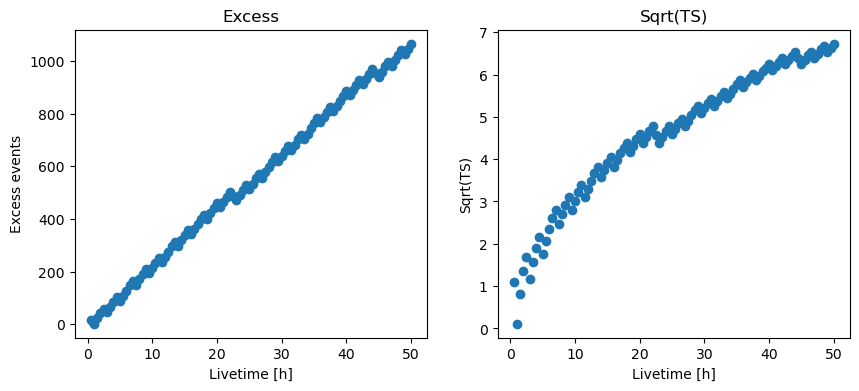

In [27]:
# We can plot the excess and the significance
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")
plt.show()

In [28]:
dataset_stacked = Datasets(datasets).stack_reduce()

In [29]:
# let's fit the data with a powerlaw model
spectral_model = PowerLawSpectralModel(amplitude = 1.1717e-13 * u.Unit("cm-2 s-1 TeV-1"),
    index = 2.3,
    reference = 1 * u.TeV,)

spectral_model.amplitude.min = 1e-15
spectral_model.amplitude.max = 1e-11
spectral_model.index.min = 1
spectral_model.index.max = 3.0

# make a SkyModel object
model = SkyModel(spectral_model=spectral_model, name="test_source")

# associate the model to the dataset
dataset_stacked.models = model

In [30]:
# set an energy range for the spectral fit
dataset_stacked.mask_fit = dataset_stacked.counts.geom.energy_mask(
    energy_min=0.1 * u.TeV, energy_max=30 * u.TeV
)

# fit the stacked dataset
fit = Fit()
result_stacked = fit.run(dataset_stacked)

print(result_stacked)
print(dataset_stacked.models.parameters.to_table())

# we make a copy here to compare it later
best_fit_model = datasets.models.copy()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 43
	total stat : 408.87

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

type    name     value         unit      ...    max    frozen link prior
---- --------- ---------- -------------- ... --------- ------ ---- -----
         index 2.6227e+00                ... 3.000e+00  False           
     amplitude 1.1532e-13 TeV-1 s-1 cm-2 ... 1.000e-11  False           
     reference 1.0000e+00            TeV ...       nan   True           


In [31]:
dataset_stacked.stat_sum()

np.float64(408.8733999012274)

In [32]:
# I use the energy bins of the dataset. The `downsample` acts reducing the number of bins of a given integer.
energy_edges = energy_axis.downsample(1).edges 

In [33]:
# let's extract points for the `test_source` model. Errors will be at 1 sigma and upper limits at 3 sigma:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="test_source", selection_optional="all", n_sigma=1, n_sigma_ul=3, n_jobs=7
)
flux_points = fpe.run(datasets=dataset_stacked)

#flux_points.sqrt_ts_threshold_ul = 2

Using 7 processes to compute Energy bins


In [34]:
flux_points.to_table()

Inferred format: gadf-sed


e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,stat_scan,is_ul,counts,success,norm_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,float64[11],bool,float64[1],bool,float64[11]
0.12589254117941673,0.10000000000000002,0.15848931924611132,2.6445035822380347e-11,1.5690914303162887e-12,1.936764684525039e-13,0.9815713073005093,0.29027405904268394,0.2895058406585087,0.2909202483796802,1.8586151737904895,11.631158107891679,3.410448373438847,11324.997156129137,387.82385,1.1641532182693481e-09,11.631158109055832,7.349267789395526 .. 179.5169588176068,False,11325.0,True,0.2 .. 4.999999999999999
0.19952623149688797,0.15848931924611132,0.251188643150958,7.90324757146303e-12,7.432068047709636e-13,1.453912546728157e-13,-0.02934048544233199,0.29596079971913825,nan,0.2969684176859119,0.8663926762758913,0.010746012441813946,-0.10366297526992917,5525.320815590934,-7.9606204,2.1736836060881615e-05,0.010767749277874827,0.6045337391551584 .. 258.2047212594189,True,5525.0,True,0.2 .. 4.999999999999999
0.316227766016838,0.251188643150958,0.3981071705534973,2.361929951441981e-12,3.5202305231284257e-13,1.0914396108229034e-13,-0.2841792531912638,0.3103235619574405,0.31190666630455155,0.3119066663019955,0.6612276803478441,0.8302836457150988,-0.9111990154269806,2549.985190094972,-50.017635,1.0064104571938515e-07,0.8302837463561445,2.39533467090223 .. 246.6030479875626,True,2550.0,True,0.2 .. 4.999999999999999
0.5011872336272724,0.3981071705534973,0.6309573444801934,7.05876039574198e-13,1.6673721037556861e-13,8.193343036718287e-14,2.908801227997513,0.36114246878531553,0.35843131349318824,0.3638931846244997,4.017400445149119,73.74066864780616,8.58723870914313,1299.9797205841164,308.31027,3.5656557884067297e-07,73.74066900437174,63.36521757398441 .. 30.80979885320994,False,1300.0,True,0.2 .. 4.999999999999999
0.7943282347242816,0.6309573444801934,1.0,2.10955021312449e-13,7.897578621959011e-14,6.150671961293948e-14,6.105854244585488,0.4986481850112627,0.4940196504485854,0.4940196504481076,nan,193.6514130593423,13.91586910901875,924.930518241756,389.92377,5.722598871216178e-06,193.65141878194117,179.52893683525326 .. 5.142370388457493,False,925.0,True,0.2 .. 4.999999999999999
1.2589254117941675,1.0,1.584893192461114,6.304509364530989e-14,3.740721579156463e-14,4.617256400215373e-14,-1.1855877466216787,0.37644674396484024,0.38344030508299687,0.383440305083665,0.008699126540678837,8.876306509682763,-2.979313093597711,174.99883540760743,-45.83479,9.378709364682436e-09,8.876306519061472,11.908985153455433 .. 165.62162443397756,True,175.0,True,0.2 .. 4.999999999999999
1.9952623149688804,1.584893192461114,2.511886431509581,1.8841380537033642e-14,1.7718086267428394e-14,3.466134562124296e-14,-0.9152231692468177,0.4814798661829216,0.49352048741464183,0.49352048741500154,0.6419108509108294,3.30086589549137,-1.8168285267166437,99.99891518608383,-20.83464,1.4137185644358397e-08,3.3008659096285555,4.809166580380406 .. 92.68674140994517,True,100.0,True,0.2 .. 4.999999999999999
3.1622776601683804,2.511886431509581,3.9810717055349736,5.630852458377143e-15,8.392246638436707e-15,2.601997325119783e-14,5.4953472262665946,0.9912923022598429,0.968298903087712,nan,nan,41.366186232408836,6.431655015033754,149.97729327645476,70.80857,3.740105967153795e-06,41.3661899725148,37.95544730684014 .. 0.25767117702343967,False,150.0,True,0.2 .. 4.999999999999999


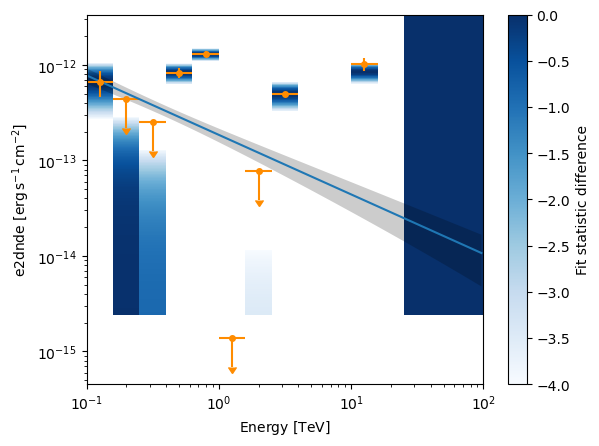

In [35]:
# Let's plot them, overlapping the significance
fig, ax = plt.subplots()
sed_type="e2dnde"
flux_points.plot(ax=ax, sed_type=sed_type, color="darkorange")
flux_points.plot_ts_profiles(ax=ax, sed_type=sed_type)
model.spectral_model.plot(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type)
model.spectral_model.plot_error(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type)
plt.show()

NameError: name 'dataset_original' is not defined

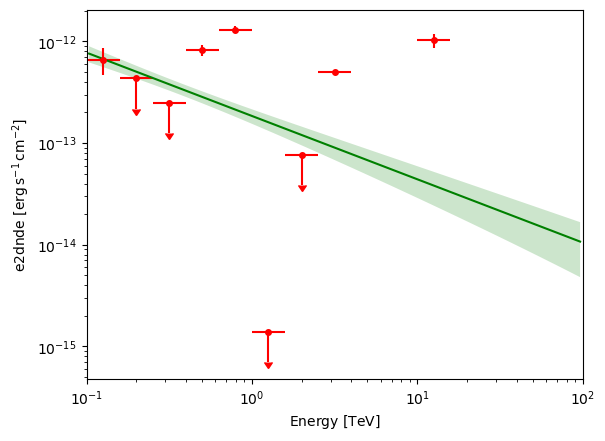

In [36]:
# Let's plot the best-fit model and the spectral points
fig, ax = plt.subplots()
sed_type="e2dnde"
flux_points.plot(ax=ax, sed_type=sed_type, color="red", label="Observed")
model.spectral_model.plot(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type, color="green", label="Best-fit")
model.spectral_model.plot_error(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type, facecolor="green")
#model.spectral_model.plot_error(ax=ax, energy_bounds=(2,10)*u.TeV, sed_type=sed_type, facecolor="green")
dataset_original[0].spectral_model.plot(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type, color="black", label="original")

plt.legend()
#plt.ylim(2e-12,2e-10)
#plt.xlim(0.5,70)

In [1]:
import logging

# %matplotlib inline
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.datasets import MapDatasetOnOff
from gammapy.estimators import ExcessMapEstimator
from gammapy.makers import RingBackgroundMaker
from gammapy.visualization import plot_distribution
from gammapy.utils.check import check_tutorials_setup

log = logging.getLogger(__name__)

In [2]:
# source_pos = SkyCoord.from_name("MSH 15-52")
source_pos = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")

config = AnalysisConfig()
# Select observations - 2.5 degrees from the source position
config.observations.datastore = "/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Fermi"
config.observations.obs_cone = {
    "frame": "icrs",
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "radius": 2.5 * u.deg,
}

config.datasets.type = "3d"
config.datasets.geom.wcs.skydir = {
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "frame": "icrs",
}  # The WCS geometry - centered on MSH 15-52
config.datasets.geom.wcs.width = {"width": "3 deg", "height": "3 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# Cutout size (for the run-wise event selection)
config.datasets.geom.selection.offset_max = 2.5 * u.deg

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.5 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We need to extract the ring for each observation separately, hence, no stacking at this stage
config.datasets.stack = False

print(config)

AnalysisConfig

    general:
        log:
            level: info
            filename: null
            filemode: null
            format: null
            datefmt: null
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Fermi
        obs_ids: []
        obs_file: null
        obs_cone:
            frame: icrs
            lon: 40.669 deg
            lat: -0.013 deg
            radius: 2.5 deg
        obs_time:
            start: null
            stop: null
        required_irf:
        - aeff
        - edisp
        - psf
        - bkg
    datasets:
        type: 3d
        stack: false
        geom:
            wcs:
                skydir:
                    frame: icrs
                    lon: 40.669 deg
                    lat: -0.013 deg
                binsize: 0.02 deg
                width:
                    width: 3.0 deg
                    h

In [3]:
analysis = Analysis(config)

# for this specific case,w e do not need fine bins in true energy
analysis.config.datasets.geom.axes.energy_true = (
    analysis.config.datasets.geom.axes.energy
)

# First get the required observations
analysis.get_observations()

print(analysis.config)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 100 out of 100.
Number of selected observations: 100


AnalysisConfig

    general:
        log:
            level: INFO
            filename: null
            filemode: null
            format: null
            datefmt: null
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Fermi
        obs_ids: []
        obs_file: null
        obs_cone:
            frame: icrs
            lon: 40.669 deg
            lat: -0.013 deg
            radius: 2.5 deg
        obs_time:
            start: null
            stop: null
        required_irf:
        - aeff
        - edisp
        - psf
        - bkg
    datasets:
        type: 3d
        stack: false
        geom:
            wcs:
                skydir:
                    frame: icrs
                    lon: 40.669 deg
                    lat: -0.013 deg
                binsize: 0.02 deg
                width:
                    width: 3.0 deg
                    h

In [4]:
analysis.get_datasets()

Creating reference dataset and makers.
Creating the background Maker.
No background maker set. Check configuration.
Start the data reduction loop.
Computing dataset for observation 0
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 0
No default lower safe energy threshold defined for obs 0
Computing dataset for observation 1
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 1
No default lower safe energy threshold defined for obs 1
Computing dataset for observation 10
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 10
No default lower safe energy threshold defined for obs 10
Computing dataset for observation 11
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 11
No default lower safe energy threshold defined for obs 11
Computing dataset for observation 12
Running MapDatasetMaker
Ru

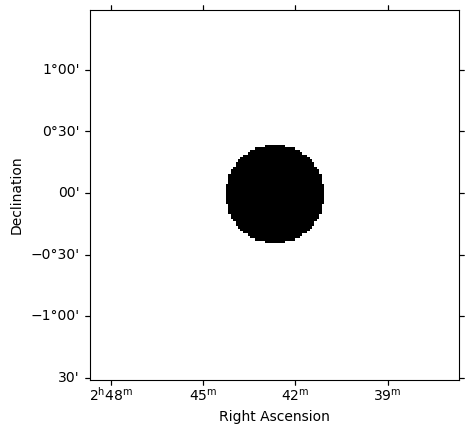

In [5]:
# get the geom that we use
geom = analysis.datasets[0].counts.geom
energy_axis = analysis.datasets[0].counts.geom.axes["energy"]
geom_image = geom.to_image().to_cube([energy_axis.squash()])

# Make the exclusion mask
regions = CircleSkyRegion(center=source_pos, radius=0.4 * u.deg)
exclusion_mask = ~geom_image.region_mask([regions])
exclusion_mask.sum_over_axes().plot()
plt.show()

In [6]:
ring_maker = RingBackgroundMaker(
    r_in="0.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask
)

In [7]:
energy_axis_true = analysis.datasets[0].exposure.geom.axes["energy_true"]
stacked_on_off = MapDatasetOnOff.create(
    geom=geom_image, energy_axis_true=energy_axis_true, name="stacked"
)

In [8]:
for dataset in analysis.datasets:
    # Ring extracting makes sense only for 2D analysis
    dataset_on_off = ring_maker.run(dataset.to_image())
    stacked_on_off.stack(dataset_on_off)

In [9]:
print(stacked_on_off)

MapDatasetOnOff
---------------

  Name                            : stacked 

  Total counts                    : 101875 
  Total background counts         : 101550.06
  Total excess counts             : 324.94

  Predicted counts                : 101550.08
  Predicted background counts     : 101550.08
  Predicted excess counts         : nan

  Exposure min                    : 6.18e+10 m2 s
  Exposure max                    : 2.21e+11 m2 s

  Number of total bins            : 22500 
  Number of fit bins              : 22500 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 374212.49

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 213695152 
  Acceptance                      : 95606 
  Acceptance off                  : 201071360 



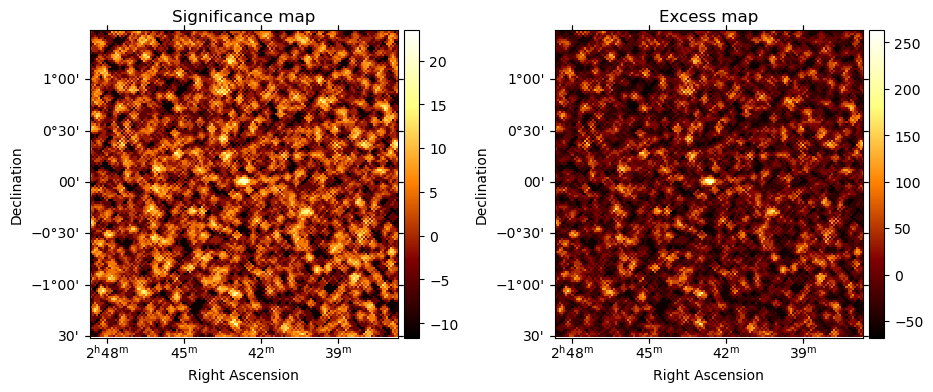

In [10]:
# Using a convolution radius of 0.04 degrees
estimator = ExcessMapEstimator(0.04 * u.deg, selection_optional=[], correlate_off=False)
lima_maps = estimator.run(stacked_on_off)

significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["npred_excess"]

# We can plot the excess and significance maps
fig, (ax1, ax2) = plt.subplots(
    figsize=(11, 4), subplot_kw={"projection": lima_maps.geom.wcs}, ncols=2
)
ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)
ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)
plt.show()

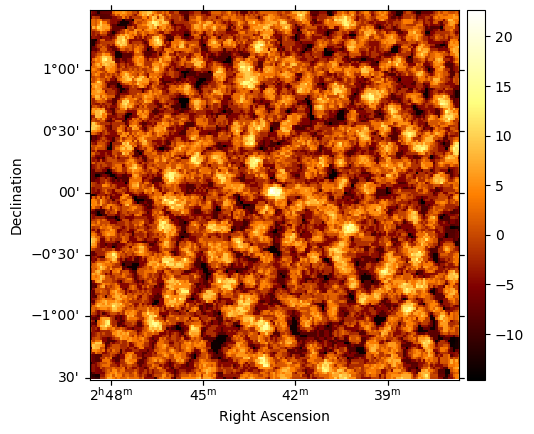

In [12]:
excess_estimator_integrated = ExcessMapEstimator(
    correlation_radius="0.05 deg", selection_optional="all", n_sigma=1,
    n_sigma_ul=5,
    energy_edges=[0.1, 100] * u.TeV,
    correlate_off=False
)
excess_integrated = excess_estimator_integrated.run(stacked_on_off)

excess_integrated["sqrt_ts"].plot(add_cbar=True)
plt.show()

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
22.675,73,76,40.69900,0.01700
18.085,104,61,40.07900,-0.28300
17.377,128,27,39.59900,-0.96300
17.012,69,135,40.77900,1.19700
16.756,71,21,40.73900,-1.08300
16.03,119,43,39.77900,-0.64300
15.914,67,88,40.81900,0.25700
15.651,69,8,40.77900,-1.34300


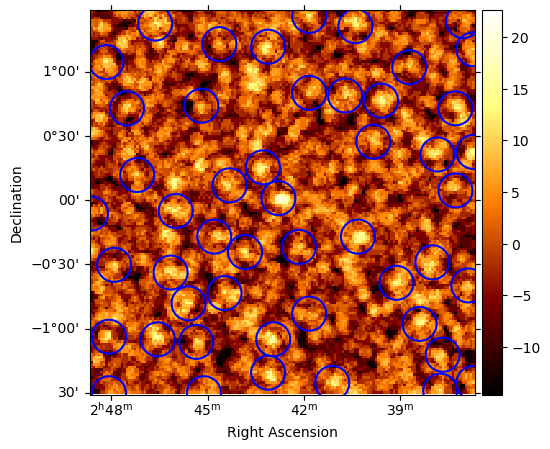

In [17]:
# set a threshold of detection at 4 sigma and a minimum distance amongst detected source of 0.2 deg:
sources = find_peaks(excess_integrated["sqrt_ts"], threshold=5, min_distance="0.2 deg")
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = excess_integrated["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"], sources["dec"],
    transform=ax.get_transform("icrs"),
    color="None", edgecolor="b", marker="o",
    s=600, lw=1.5,
)
plt.show()

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/stats/counts_statistic.py:398: RuntimeWarning: invalid value encountered in multiply
  return self.alpha * self.n_off
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/stats/fit_statistics.py:207: RuntimeWarning: invalid value encountered in multiply
  C = alpha * (n_on + n_off) - (1 + alpha) * mu_sig
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/stats/fit_statistics.py:208: RuntimeWarning: invalid value encountered in multiply
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


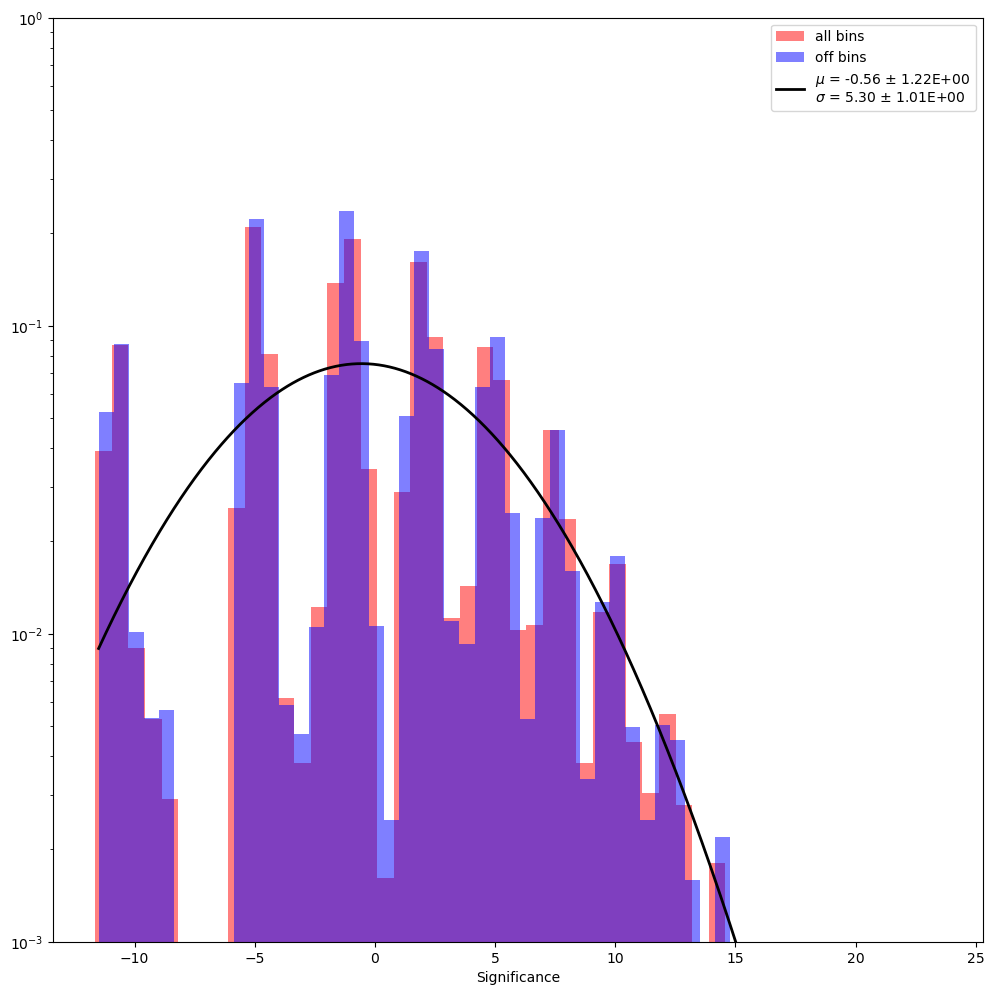

In [12]:
# Mask the regions with gamma-ray emission
stacked_on_off.mask_fit = exclusion_mask
lima_maps2 = estimator.run(stacked_on_off)
significance_map_off = lima_maps2["sqrt_ts"]

kwargs_axes = {"xlabel": "Significance", "yscale": "log", "ylim": (1e-3, 1)}
ax, _ = plot_distribution(
    significance_map,
    kwargs_hist={
        "density": True,
        "alpha": 0.5,
        "color": "red",
        "label": "all bins",
        "bins": 51,
    },
    kwargs_axes=kwargs_axes,
)

ax, res = plot_distribution(
    significance_map_off,
    ax=ax,
    func="norm",
    kwargs_hist={
        "density": True,
        "alpha": 0.5,
        "color": "blue",
        "label": "off bins",
        "bins": 51,
    },
    kwargs_axes=kwargs_axes,
)

plt.show()
# sphinx_gallery_thumbnail_number = 2